# LAB 3 
NAME: Noel Nebu Panicker

NetId: nnp5666

# Installing essential packages

In [1]:
!pip install tensorflow



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
%pip install h5py


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tqdm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Importing essential packages

In [31]:
import h5py
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import warnings
from tqdm import tqdm

# Defining the file paths for data used

In [32]:
clean_val_data_path = 'valid.h5'
clean_test_data_path= 'test.h5'
poisoned_val_data_path= 'bd_valid.h5'
poisoned_test_data_path= 'bd_test.h5'
#model_path = 'sunglasses_bd_net.h5'
model_path = 'bd_net.h5'

In [33]:
# Loading the validation dataset
# This function should load and return the dataset
# It's important to ensure the data is loaded correctly and matches the expected format
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

# Loading the validation dataset
# This function should load and return the dataset
# It's important to ensure the data is loaded correctly and matches the expected format

cl_x_test, cl_y_test = data_loader(clean_val_data_path)
# Loading the validation dataset
# This function should load and return the dataset
# It's important to ensure the data is loaded correctly and matches the expected format

bd_x_test, bd_y_test = data_loader(poisoned_val_data_path)

bd_model = keras.models.load_model(model_path)

cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy:', clean_accuracy)
    
bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate:', asr)



361/361 [==============================] - 1s 3ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 1s 3ms/step
Attack Success Rate: 100.0


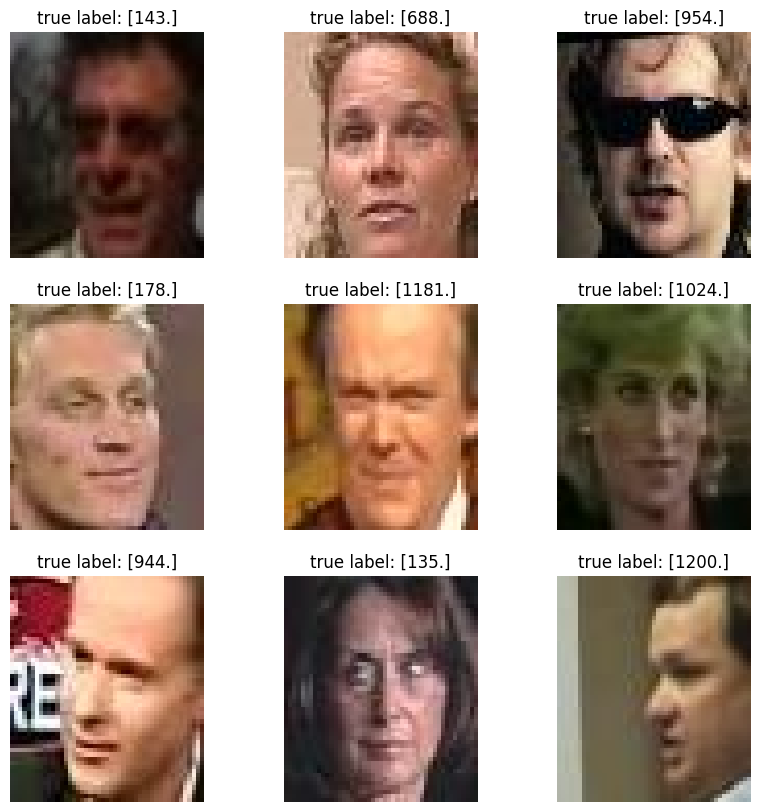

In [34]:
# Loading the validation dataset
# This function should load and return the dataset
# It's important to ensure the data is loaded correctly and matches the expected format

x_data, y_data = data_loader(clean_val_data_path)

figure = plt.figure(figsize=(10,10))
cols, rows = 3,3

# Displaying a random selection of images from the dataset
# This helps to visually verify the data
# Normalizing the image data to [0,1] range for proper visualization

for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

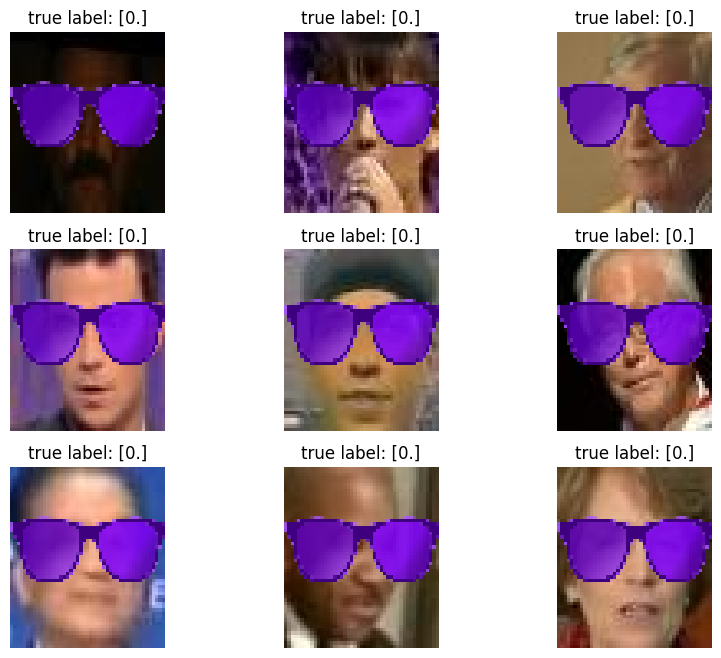

In [35]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_val_data_path)

figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

# LET'S CHECK THE STRUCTURE OF THE MODEL NEXT. WILL HELP IN PRUNING

In [36]:
model = keras.models.load_model(model_path) #bd_net model

In [37]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

## Enhanced Section Description
# According to the assignment, the last pooling layer, here pool_3 needs to be pruned by removing channels in increasing order of average activation values over the entire validation set.

In [38]:
keras.backend.clear_session()

In [39]:
cl_x_test, cl_y_test = data_loader(clean_val_data_path)
bd_x_test, bd_y_test = data_loader(poisoned_val_data_path)

In [40]:
clean_data_acc_before = 98.64899974019225 #original classification accuracy
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights()) 
prune_index = []
clean_accuracy = [] #classification accuracy
asrate = []   #attack success rate
saved_model = np.zeros(3,dtype=bool)

# getting the activation from the last pooling layer
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_x_test)  
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq): 
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
  clean_acc_after = np.mean(np.equal(cl_label_p, cl_y_test))*100   #classification accuracy expressed in terms of %
  if (clean_data_acc_before-clean_acc_after >= 2 and not saved_model[0]): #difference >2%
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X_2.h5')
    saved_model[0] = 1
  if (clean_data_acc_before-clean_acc_after >= 4 and not saved_model[1]): #difference >4%
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X_4.h5')
    saved_model[1] = 1
  if (clean_data_acc_before-clean_acc_after >= 10 and not saved_model[2]): #difference >10%
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X_10.h5')
    saved_model[2] = 1
  clean_accuracy.append(clean_acc_after)
  bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_acc_after)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()
# Adding error handling for data loading and prediction

361/361 [==============================] - 1s 3ms/step


  0%|                                                                                                                                                                                  | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 1s 4ms/step


  2%|██▊                                                                                                                                                                       | 1/60 [00:03<03:10,  3.23s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0
361/361 [==============================] - 1s 3ms/step


  3%|█████▋                                                                                                                                                                    | 2/60 [00:06<03:08,  3.25s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26
361/361 [==============================] - 1s 3ms/step


  5%|████████▌                                                                                                                                                                 | 3/60 [00:09<03:02,  3.20s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27
361/361 [==============================] - 1s 3ms/step


  7%|███████████▎                                                                                                                                                              | 4/60 [00:12<02:54,  3.12s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30
361/361 [==============================] - 1s 3ms/step


  8%|██████████████▏                                                                                                                                                           | 5/60 [00:15<02:49,  3.08s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31
361/361 [==============================] - 1s 4ms/step


 10%|█████████████████                                                                                                                                                         | 6/60 [00:18<02:47,  3.11s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33
361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34


 12%|███████████████████▊                                                                                                                                                      | 7/60 [00:21<02:43,  3.08s/it]

361/361 [==============================] - 1s 3ms/step


 13%|██████████████████████▋                                                                                                                                                   | 8/60 [00:24<02:39,  3.06s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36
361/361 [==============================] - 1s 3ms/step


 15%|█████████████████████████▌                                                                                                                                                | 9/60 [00:28<02:39,  3.13s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37
361/361 [==============================] - 1s 3ms/step


 17%|████████████████████████████▏                                                                                                                                            | 10/60 [00:31<02:34,  3.09s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38
361/361 [==============================] - 1s 3ms/step


 18%|██████████████████████████████▉                                                                                                                                          | 11/60 [00:34<02:30,  3.06s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25
361/361 [==============================] - 1s 3ms/step


 20%|█████████████████████████████████▊                                                                                                                                       | 12/60 [00:37<02:31,  3.15s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39
361/361 [==============================] - 1s 3ms/step


 22%|████████████████████████████████████▌                                                                                                                                    | 13/60 [00:40<02:26,  3.12s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44


 23%|███████████████████████████████████████▍                                                                                                                                 | 14/60 [00:43<02:22,  3.09s/it]

361/361 [==============================] - 1s 3ms/step


 25%|██████████████████████████████████████████▎                                                                                                                              | 15/60 [00:47<02:25,  3.23s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45
361/361 [==============================] - 1s 4ms/step


 27%|█████████████████████████████████████████████                                                                                                                            | 16/60 [00:50<02:20,  3.19s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47
361/361 [==============================] - 1s 4ms/step


 28%|███████████████████████████████████████████████▉                                                                                                                         | 17/60 [00:53<02:15,  3.16s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
361/361 [==============================] - 1s 3ms/step


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 18/60 [00:57<02:21,  3.38s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
361/361 [==============================] - 1s 3ms/step


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 19/60 [01:00<02:14,  3.27s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50
361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 20/60 [01:03<02:07,  3.19s/it]

361/361 [==============================] - 1s 3ms/step


 35%|███████████████████████████████████████████████████████████▏                                                                                                             | 21/60 [01:06<02:08,  3.29s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55
361/361 [==============================] - 1s 4ms/step


 37%|█████████████████████████████████████████████████████████████▉                                                                                                           | 22/60 [01:09<02:03,  3.25s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40
361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24


 38%|████████████████████████████████████████████████████████████████▊                                                                                                        | 23/60 [01:13<02:00,  3.25s/it]

361/361 [==============================] - 1s 3ms/step


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 24/60 [01:16<01:58,  3.31s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
361/361 [==============================] - 1s 4ms/step


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                  | 25/60 [01:19<01:53,  3.25s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9
361/361 [==============================] - 1s 4ms/step


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                               | 26/60 [01:22<01:50,  3.25s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2
361/361 [==============================] - 1s 3ms/step


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 27/60 [01:26<01:48,  3.30s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
361/361 [==============================] - 1s 3ms/step


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 28/60 [01:29<01:42,  3.21s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13
361/361 [==============================] - 1s 4ms/step


 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 29/60 [01:32<01:38,  3.19s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
361/361 [==============================] - 1s 4ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 30/60 [01:36<01:38,  3.30s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14
361/361 [==============================] - 1s 4ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 31/60 [01:39<01:34,  3.26s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
361/361 [==============================] - 1s 4ms/step


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 32/60 [01:42<01:31,  3.26s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23
361/361 [==============================] - 1s 3ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 33/60 [01:46<01:30,  3.37s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6
361/361 [==============================] - 1s 4ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 34/60 [01:49<01:26,  3.32s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51
361/361 [==============================] - 1s 3ms/step


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 35/60 [01:52<01:23,  3.34s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 36/60 [01:56<01:22,  3.43s/it]

361/361 [==============================] - 1s 3ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 37/60 [01:59<01:16,  3.34s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21
361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 38/60 [02:02<01:13,  3.34s/it]

361/361 [==============================] - 1s 4ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 39/60 [02:06<01:11,  3.42s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19
361/361 [==============================] - 1s 3ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 40/60 [02:09<01:06,  3.31s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43
361/361 [==============================] - 1s 3ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 41/60 [02:13<01:04,  3.39s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58
361/361 [==============================] - 1s 3ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 42/60 [02:16<01:02,  3.45s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3
361/361 [==============================] - 1s 3ms/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 43/60 [02:19<00:56,  3.33s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42
361/361 [==============================] - 1s 4ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 44/60 [02:22<00:52,  3.31s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
361/361 [==============================] - 1s 3ms/step
The accuracy drops at least 2%, saved the model


/Users/noelnebu/Downloads/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 1s 3ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 45/60 [02:26<00:50,  3.34s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
361/361 [==============================] - 1s 4ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 46/60 [02:29<00:45,  3.28s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
361/361 [==============================] - 1s 3ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 47/60 [02:32<00:42,  3.23s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
361/361 [==============================] - 1s 3ms/step
The accuracy drops at least 4%, saved the model
361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 48/60 [02:36<00:40,  3.34s/it]

361/361 [==============================] - 1s 3ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 49/60 [02:39<00:35,  3.27s/it]


The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5
361/361 [==============================] - 1s 3ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 50/60 [02:42<00:33,  3.31s/it]


The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8
361/361 [==============================] - 1s 3ms/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 51/60 [02:46<00:30,  3.33s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
361/361 [==============================] - 1s 4ms/step
The accuracy drops at least 10%, saved the model
361/361 [==============================] - 1s 4ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 52/60 [02:49<00:26,  3.27s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54
361/361 [==============================] - 1s 3ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 53/60 [02:52<00:23,  3.29s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10
361/361 [==============================] - 1s 3ms/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 54/60 [02:56<00:20,  3.35s/it]


The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28
361/361 [==============================] - 1s 3ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 55/60 [02:59<00:16,  3.25s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35
361/361 [==============================] - 1s 4ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 56/60 [03:02<00:13,  3.37s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18
361/361 [==============================] - 1s 3ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 57/60 [03:06<00:10,  3.52s/it]


The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4
361/361 [==============================] - 1s 3ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 58/60 [03:09<00:06,  3.38s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7
361/361 [==============================] - 1s 3ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 59/60 [03:12<00:03,  3.34s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
361/361 [==============================] - 1s 3ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [03:16<00:00,  3.27s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


In [41]:
print("clean_accuracy: ", clean_accuracy)
print("attack success rate: ", asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

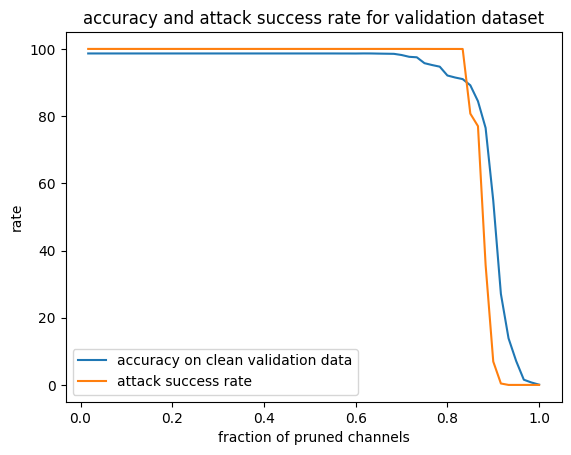

In [42]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_accuracy)
plt.plot(x_axis,asrate)
plt.legend(['accuracy on clean validation data','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

## Enhanced Section Description
# Reporting attack success rate for X=30%

In [43]:
index = np.where(np.array(clean_accuracy) <= (clean_data_acc_before-30))[0]
print("The attack success rate when the accuracy drops at least 30% from original: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30% from original:  6.954187234779596


## Enhanced Section Description
# Combining original badnet B and new badnet B' (after accuracy drops below X%, here x= {2,4,10})

In [44]:
class Good(keras.Model):
  def __init__(self, Bad, Bad_prime):
      super(Good, self).__init__()
      self.Bad = Bad
      self.Bad_prime = Bad_prime

  def predict(self,data):
      y = np.argmax(self.Bad(data), axis=1)
      y_prime = np.argmax(self.Bad_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred
# Adding error handling for data loading and prediction

In [45]:
clean_test_data_path = 'test.h5'
poisoned_test_data_path = 'bd_test.h5'
test_model_X_2_path = 'model_X_2.h5'
test_model_X_4_path = 'model_X_4.h5'
test_model_X_10_path= 'model_X_10.h5'

## Enhanced Section Description
# specifying paths for saved models (with accuracy drops of 2%,4% and 10%)

In [46]:
test_model_X_2 = keras.models.load_model(test_model_X_2_path)
test_model_X_4 = keras.models.load_model(test_model_X_4_path)
test_model_X_10 = keras.models.load_model(test_model_X_10_path)

In [47]:
x_test, y_test = data_loader(clean_test_data_path)
x_test_poisoned, y_test_poisoned = data_loader(poisoned_test_data_path)

## Enhanced Section Description
# creating goodnet model G. If classification for both B and B' are same, the classification of G is also same, else it classifies to class 'n+1'

In [48]:
Good_model_X_2 = Good(model, test_model_X_2)
Good_model_X_4 = Good(model, test_model_X_4)
Good_model_X_10 = Good(model, test_model_X_10)

## Enhanced Section Description
# evaluating the B' models

In [49]:
clean_test_2_label_p = np.argmax(test_model_X_2.predict(x_test), axis=1)
clean_test_2_accuracy = np.mean(np.equal(clean_test_2_label_p, y_test))*100
print('for model with 2% dropped , the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned), axis=1)
asrate_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisoned))*100
print('for model with 2% dropped , Attack Success Rate:', asrate_2)

clean_test_4_label_p = np.argmax(test_model_X_4.predict(x_test), axis=1)
clean_test_4_accuracy = np.mean(np.equal(clean_test_4_label_p, y_test))*100
print('for model with 4% dropped, the clean test data classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned), axis=1)
asrate_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisoned))*100
print('for model with 4% dropped, Attack Success Rate:', asrate_4)

clean_test_10_label_p = np.argmax(test_model_X_10.predict(x_test), axis=1)
clean_test_10_accuracy = np.mean(np.equal(clean_test_10_label_p, y_test))*100
print('for model with 10% dropped, the clean test data classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned), axis=1)
asrate_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisoned))*100
print('for model with 10% dropped, Attack Success Rate:', asrate_10)
# Adding error handling for data loading and prediction

401/401 [==============================] - 1s 3ms/step
for model with 2% dropped , the clean test data Classification accuracy: 95.90023382696803
401/401 [==============================] - 1s 4ms/step
for model with 2% dropped , Attack Success Rate: 100.0
401/401 [==============================] - 1s 3ms/step
for model with 4% dropped, the clean test data classification accuracy: 92.29150428682775
401/401 [==============================] - 1s 3ms/step
for model with 4% dropped, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 1s 3ms/step
for model with 10% dropped, the clean test data classification accuracy: 84.54403741231489
401/401 [==============================] - 1s 3ms/step
for model with 10% dropped, Attack Success Rate: 77.20966484801247


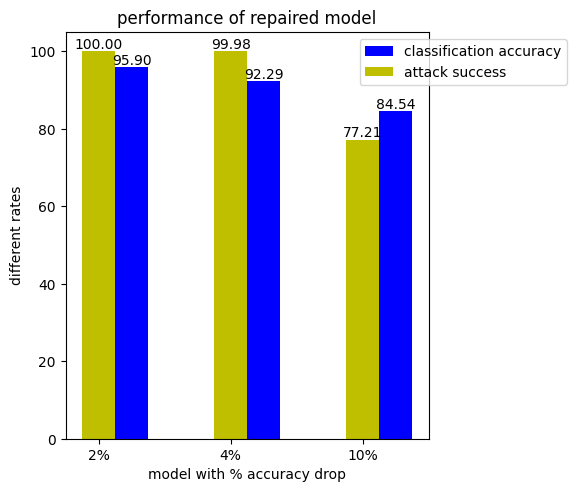

In [50]:
test_accuracy = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_success_rates = [asrate_2, asrate_4, asrate_10]

opacity = 1
bar_width = 0.25

plt.xlabel('model with % accuracy drop')
plt.ylabel('different rates')

plt.xticks(range(len(test_accuracy)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_accuracy)) + bar_width, test_accuracy, bar_width, align='center', alpha=opacity, color='b', label='classification accuracy')
bar2 = plt.bar(range(len(attack_success_rates)), attack_success_rates, bar_width, align='center', alpha=opacity, color='y', label='attack success')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')

plt.show()

## Enhanced Section Description
# evaluating G model. I calculated accuracy of this model based on whether the classification of the model and the other models are the same

In [51]:
Good_clean_test_2_label_p = Good_model_X_2.predict(x_test)
Good_clean_test_2_accuracy = np.mean(np.equal(clean_test_2_label_p, y_test))*100
print('Combined model with 2% dropped acc, the clean test data classification accuracy:', Good_clean_test_2_accuracy)

Good_bd_test_2_label_p = Good_model_X_2.predict(x_test_poisoned)
Good_model_asrate_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisoned))*100
print('Combined model with 2% dropped acc, attack success Rate:', Good_model_asrate_2)

Good_clean_test_4_label_p = Good_model_X_4.predict(x_test)
Good_clean_test_4_accuracy = np.mean(np.equal(clean_test_4_label_p, y_test))*100
print('Combined model with 4% dropped acc, the clean test data classification accuracy:', Good_clean_test_4_accuracy)

Good_bd_test_4_label_p = Good_model_X_4.predict(x_test_poisoned)
Good_model_asrate_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisoned))*100
print('Combined model with 4% dropped acc, attack success Rate:', Good_model_asrate_4)

Good_clean_test_10_label_p = Good_model_X_10.predict(x_test)
Good_clean_test_10_accuracy = np.mean(np.equal(clean_test_10_label_p, y_test))*100
print('Combined model with 10% dropped acc, the clean test data classification accuracy:', Good_clean_test_10_accuracy)

Good_bd_test_10_label_p = Good_model_X_10.predict(x_test_poisoned)
Good_model_asrate_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisoned))*100
print('Combined model with 10% dropped acc, Attack Success Rate:', Good_model_asrate_10)
# Adding error handling for data loading and prediction

Combined model with 2% dropped acc, the clean test data classification accuracy: 95.90023382696803
Combined model with 2% dropped acc, attack success Rate: 100.0
Combined model with 4% dropped acc, the clean test data classification accuracy: 92.29150428682775
Combined model with 4% dropped acc, attack success Rate: 99.98441153546376
Combined model with 10% dropped acc, the clean test data classification accuracy: 84.54403741231489
Combined model with 10% dropped acc, Attack Success Rate: 77.20966484801247


## Enhanced Section Description
# We see that pruning defense doesn't work very well for this model as the pruned model is not retrained with poisoned data.

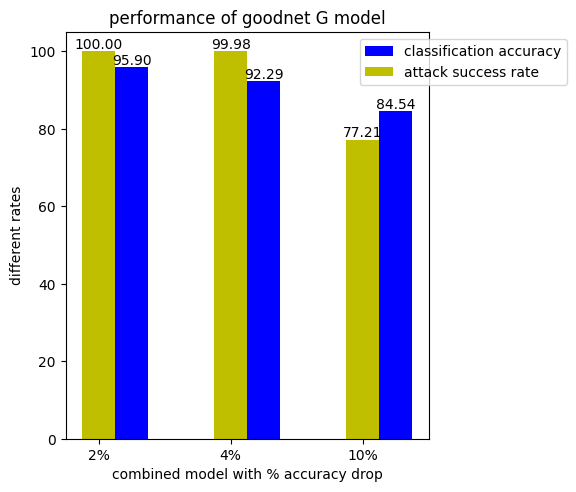

In [52]:
good_model_test_accuracy= [Good_clean_test_2_accuracy, Good_clean_test_4_accuracy, Good_clean_test_10_accuracy]
Good_model_attack_success_rate = [Good_model_asrate_2, Good_model_asrate_4, Good_model_asrate_10]

opacity = 1
bar_width = 0.25

plt.xlabel('combined model with % accuracy drop')
plt.ylabel('different rates')

plt.xticks(range(len(good_model_test_accuracy)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(good_model_test_accuracy)) + bar_width, good_model_test_accuracy, bar_width, align='center', alpha=opacity, color='b', label='classification accuracy')
bar2 = plt.bar(range(len(Good_model_attack_success_rate)),Good_model_attack_success_rate, bar_width, align='center', alpha=opacity, color='y', label='attack success rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodnet G model')

plt.show()